In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import networkx as nx

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

In [4]:
sys.path.append("/home/rzhu/Documents/nwn_l2l/")
from nwnTorch.jn_models import *
from nwnTorch.nwn import *
from nwnTorch.generate_adj import *
from nwnTorch.misc import *

In [5]:
con     = pkl_load("/home/rzhu/data_access/l2l_data/volterra_data/con0.pkl")
adj     = torch.tensor(con["adj_matrix"])
net     = NWN(adj, "sydney")

In [6]:
net                     = NWN(adj, "sydney")
E                       = net.number_of_junctions
net.params["Ron"]       = 1e1
net.params["Roff"]      = 1e4
net.params["grow"]      = 5
net.params["decay"]     = 10
net.params["precision"] = True
net.params["collapse"]  = False
net.params["dt"]        = 1e-3
# net.junction_state.L    = torch.rand(E) * 0.3 - 0.15

net.junction_state.updateG()

In [7]:
netV = torch.zeros(10000,1024)
netL = torch.zeros(10000,E)

In [8]:
for t in tqdm(range(10000)):
    sig_in    = torch.zeros(2)
    sig_in[0] = 1
    net.sim(sig_in.reshape(1,-1), [118,211])
    netV[t] = net.V
    netL[t] = net.junction_state.L
    # netG[t]   = net.I[-1]
    # readL0[t] = test_net.junction_state.L[:]

100%|██████████| 10000/10000 [00:46<00:00, 217.07it/s]


In [9]:
Graph = nx.from_numpy_array(np.array(adj))
layout = nx.kamada_kawai_layout(Graph)

In [10]:
def get_on_mat(net, L):
    switch = abs(L) > net.params["Lcrit"]
    adj_on = torch.zeros(net.adjMat.shape)
    adj_on[net.junction_list[:,0], net.junction_list[:,1]] = switch.float()
    adj_on = adj_on + adj_on.T

    return adj_on

def get_on_graph(net, L):
    from networkx import from_numpy_array
    adj_on  = get_on_mat(net, L)
    onGraph = from_numpy_array(np.array(adj_on))
    return onGraph

def find_WTA_path(net, lambda_mat, source, drain):
    """
    lambda_mat: (T, E), time-series matrix for filament states
    """
    from networkx import has_path, all_simple_paths

    T = lambda_mat.shape[0]
    for t in range(T):
        onGraph = get_on_graph(net, lambda_mat[t])
        formed = has_path(onGraph, source, drain)
        if formed:
            form_time = t
            paths     = [i for i in all_simple_paths(onGraph, source, drain)]
            break
    return form_time, paths

In [11]:
lambda_dict = pkl_load("/home/rzhu/data_access/l2l_data/volterra_data/lambda_data.pkl")

In [12]:
# Custom cmap
import matplotlib.colors
carray    = np.array(["73F74B","ECD77F","BC2E2B"])
clist     = [[v/255 for v in bytes.fromhex(c)] for c in carray]
node_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",
                                                           clist)

In [13]:
frame   = 3000
Ls      = lambda_dict["lambda"]
ONmat   = get_on_mat(net, Ls[frame])

In [14]:
ONnodes = np.unique(np.where(ONmat))
nodes_dist_to_source = np.array([nx.shortest_path_length(Graph, 118, node) for node in ONnodes])

In [15]:
ONedges = np.array(np.where(ONmat)).T
edges_dist_to_source = []

for edge in ONedges:
    dist1  = nx.shortest_path_length(Graph, 118, edge[0])
    dist2  = nx.shortest_path_length(Graph, 118, edge[1])
    edges_dist_to_source.append((dist1 + dist2)/2)

edges_dist_to_source = np.array(edges_dist_to_source)
edgeV = (netV[frame, ONedges[:,0]] + netV[frame, ONedges[:,1]])/2
# edgeV = abs(netV[frame, ONedges[:,0]] - netV[frame, ONedges[:,1]])

In [16]:
net.junction_state.L = Ls[frame]
net.junction_state.updateG()
MIDedges_idx = np.where(net.junction_state.G > 1e-4)[0]
MIDedges = np.array(net.junction_list[MIDedges_idx])
# MIDedge_disp = np.array(net.junction_state.G[MIDedges_idx])

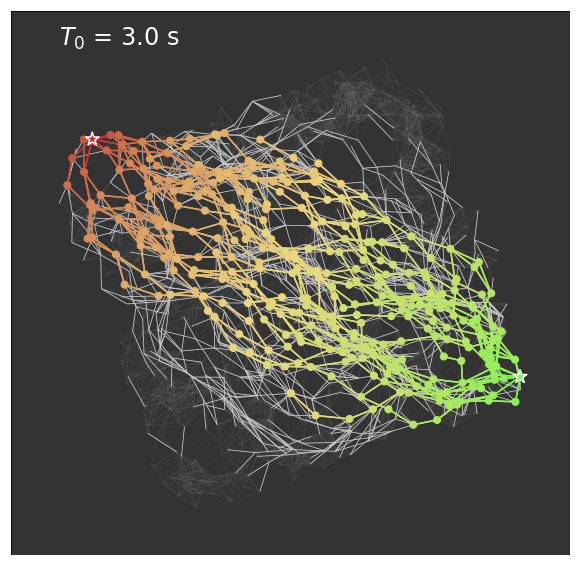

In [47]:
fig, ax = plt.subplots(figsize = (10,10))

ax.set_facecolor("#333333")
# ax.set_facecolor("#666666")

# * Draw the whole network as a base layer
nx.draw_networkx(Graph, 
                    ax = ax,
                    edge_color = "#717171", 
                    pos = layout, 
                    with_labels=False,
                    node_size = 0, 
                    # node_size = 20, 
                    # node_color = -netV[frame],
                    # cmap = node_cmap,
                    node_color = "#3B27A8",
                    # node_color = "#557c93", 
                    width = .15)

# * draw ON nodes
onplot = nx.draw_networkx_nodes(Graph, 
                        ax = ax,
                        pos = layout,
                        nodelist = ONnodes,
                        node_size = 50,
                        cmap = node_cmap,
                        node_color = netV[frame, ONnodes],
                        vmin = 0, vmax = 1,
                        # node_color = nodes_dist_to_source,
                        )

nx.draw_networkx_nodes(Graph, 
                        ax = ax,
                        pos = layout,
                        nodelist = [118, 211],
                        node_size = 200,
                        # cmap = node_cmap,
                        node_color = ["#"+carray[-1], "#"+carray[0]],
                        node_shape = "*", 
                        edgecolors = "w",
                        linewidths = 1.5,
                        )

nx.draw_networkx_edges(Graph, 
                        ax = ax,
                        pos = layout,
                        edgelist = MIDedges,
                        # edge_color = "#9C9C9C", 
                        edge_color = "#C9C9C9", 
                        # edge_color = "w",
                        width = 0.8,
                        # edge_cmap = node_cmap,
                        )
# * draw ON edges
nx.draw_networkx_edges(Graph, 
                        ax = ax,
                        pos = layout,
                        edgelist = ONedges,
                        # edge_color = "w", 
                        # edge_color = edges_dist_to_source,
                        edge_color = np.array(edgeV),
                        width = 1.5,
                        edge_cmap = node_cmap,
                        # edge_vmin = 0,
                        # edge_vmax = 1,
                        )

ax.text(-1,1, rf"$T_0$ = {frame/1000:.3} s", color = "w", fontsize=24)
plt.savefig(f"snapshots/frame_{frame}.pdf")
# ax.arrow(layout[118][0] - 0.05, layout[118][1] + 0.05, -.1, .1, shape = "full")
# fig.colorbar(onplot, ax = ax, label = "Voltage (V)")

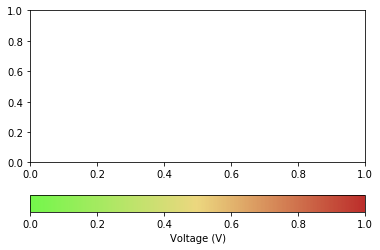

In [18]:
sm = plt.cm.ScalarMappable(cmap=node_cmap, norm=plt.Normalize(vmin = 0, vmax=1))
sm._A = []
plt.colorbar(sm, orientation = "horizontal", label = "Voltage (V)")
plt.savefig("snapshots/colorbar.pdf")

In [20]:
np.random.seed(0)
elec_out  = np.random.choice(1024, size = (1,64), replace=None)

In [37]:
import matplotlib as mpl
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True  

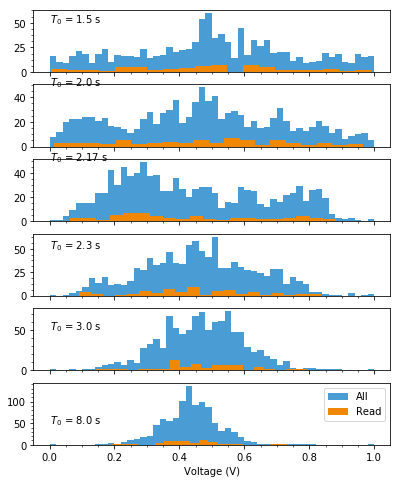

In [44]:
times = [1500, 2000, 2170, 2300, 3000, 8000]

fig, axes = plt.subplots(len(times),1, figsize=(6.4,8))


for i, t in enumerate(times):
    if i < len(times) - 1: 
            axes[i].tick_params('x', labelbottom=False)
    axes[i].hist(netV[t], 50, label = "All", color = "#4A9CD5")
    axes[i].hist(netV[t,elec_out], 20, label = "Read", color = "#F18805")
    # axes[i].set_ylim(1, 50)
    # axes[i].set_yscale("log")
    axes[i].text(0, 50, rf"$T_0$ = {t/1000} s")


axes[-1].set_xlabel("Voltage (V)")
axes[-1].legend()
# axes[0].set_title("Voltage distribution")
# plt.savefig("voltage_dist.pdf")

Text(0.5, 1.0, 'Memory distribution')

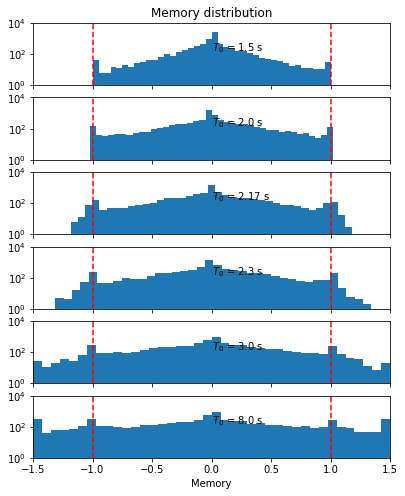

In [22]:
# times = [0, 1500, 2000, 2170, 2300, 8000]

fig, axes = plt.subplots(len(times),1, figsize=(6.4,8))


for i,t in enumerate(times):
    if i < len(times) - 1: 
            axes[i].tick_params('x', labelbottom=False)
    axes[i].hist(netL[t] / 0.1, 40)
    axes[i].set_ylim(1, 10000)
    axes[i].set_xlim(-1.5, 1.5)
    axes[i].axvline(1, ls = "--", c ="r")
    axes[i].axvline(-1, ls = "--", c ="r")

    axes[i].set_yscale("log")
    axes[i].text(0, 150, rf"$T_0$ = {t/1000} s")


axes[-1].set_xlabel("Memory")
axes[0].set_title("Memory distribution")